In [1]:
import os
import math
import time
import random
import itertools
import operator
import urllib.parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import  Adam


Using TensorFlow backend.


In [2]:
random.seed(9001)
%matplotlib inline
pd.options.mode.chained_assignment = None


In [3]:
# loading dataset
def loadFile(path):
    directory = str(os.getcwd())
    filepath = directory + "/" + path
    data = list(set(open(filepath,'r').readlines()))
    
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))
        result.append(d)
    
    result = list(set(result))
    return result

# make dictionary and counts_matrix
def dic(X, model):
    t0 = time.time()

    print (str(model))
    counts_matrix = model.fit_transform(X) #sparse matrix
    all_counts = np.log10(counts_matrix.sum(axis=0).getA1()) #calculate score of each word
    ngrams_list = model.get_feature_names() #list the word and score
    
    _sorted_ngrams = sorted(zip(ngrams_list, all_counts), key=operator.itemgetter(1), reverse=True)
    print('All NGrams: %d' % len(_sorted_ngrams))

    for ngram, count in _sorted_ngrams[:10]:
        print(ngram, count)
    
    t1 = time.time()
    print("It cost %f sec" % (t1 - t0))
    return counts_matrix, all_counts, model

# split and minmax
def split(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=9001) #splitting data

    cw0 = df.label.value_counts()[0]/df.shape[0]
    cw1 = df.label.value_counts()[1]/df.shape[0]
    
    print ("size of train :", X_train.shape[0])
    print ("size of val   :", X_val.shape[0])
    print ("------------------------------------")
    print ("class_weight :", cw0, cw1)
    return X_train, X_val, y_train, y_val, cw0, cw1

# Evaluation
def evaluation(model, X_val, y_val):
    print (str(model))
    predicted = model.predict(X_val)
    
    fpr, tpr, _ = roc_curve(y_val, (model.predict_proba(X_val)[:, 1]))
    auc_ = auc(fpr, tpr)

    print("------------------------------------")
    print("Baseline    : %.6f" % (1 - sum(y_val)/y_val.shape[0]))
    print("Accuracy    : %f" % model.score(X_val, y_val))  #checking the accuracy
    print("Precision   : %f" % precision_score(y_val, predicted))
    print("Recall      : %f" % recall_score(y_val, predicted))
    print("F1-Score    : %f" % f1_score(y_val, predicted))
    print("AUC         : %f" % auc_)



In [4]:
# loading dataset convert to dataframe
badQueries = loadFile('badqueries.txt')
validQueries = loadFile('goodqueries.txt')
queries = badQueries + validQueries

yBad = [1 for i in range(0, len(badQueries))]
yGood = [0 for i in range(0, len(validQueries))]
y = yBad + yGood

df = pd.DataFrame(queries, columns=["domain"])
con = pd.DataFrame(df.domain.str.split("\n",2).tolist(), columns = ['domain','b','c'])
df = pd.concat([con[["domain"]], pd.DataFrame(y, columns=["label"])], axis=1)
df = shuffle(df).reset_index(drop=True)

del con
print ("size of bad query   :", len(yBad))
print ("size of good query  :", len(yGood))
print ("size of total query :", len(y))
df.head()

size of bad query   : 44532
size of good query  : 1265974
size of total query : 1310506


,domain,label
0,/film53/,0
1,/20061213155630/,0
2,/javascript/head.phtml,0
3,/computer_books/,0
4,/ar2006122300792/,0


In [5]:
# hold out
train = df[df.index % 10 != 1].reset_index(drop = True)
test = df[df.index % 10 == 1].reset_index(drop = True)

print ("size of hold_out :", test.shape[0])
print ("size of training :", train.shape[0])
print (train.label.value_counts())
print (test.label.value_counts())

size of hold_out : 131051
size of training : 1179455
0    1139396
1      40059
Name: label, dtype: int64
0    126578
1      4473
Name: label, dtype: int64


### TfidfVectorizer matrix

In [6]:
N = (1, 3)
tfidf = TfidfVectorizer(min_df = 0.0, analyzer = "char", decode_error = "ignore",
                        sublinear_tf = True, ngram_range = N)

cm_tfidf, count_tfidf, m_tfidf = dic(X=train.domain, model=tfidf)


TfidfVectorizer(analyzer='char', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
All NGrams: 94073
/ 4.80821138294
a 4.64846321395
s 4.5985591916
e 4.59722185318
t 4.58849169492
r 4.57501559799
i 4.57168821775
0 4.55431157933
1 4.52062609322
c 4.51826557797
It cost 48.589547 sec


In [7]:
print('Size of data: %d' % cm_tfidf.shape[0])
print('Dim of data : %d' % cm_tfidf.shape[1])

Size of data: 1179455
Dim of data : 94073


In [8]:
X = cm_tfidf
y = np.array(train[["label"]]).reshape(train.shape[0], )

X_train, X_val, y_train, y_val, cw0, cw1 = split(X, y)

size of train : 943564
size of val   : 235891
------------------------------------
class_weight : 0.966019232266 0.033980767734


In [9]:
# Training
t0 = time.time()
lgs = LogisticRegression(class_weight = {1: cw1, 0: cw0}) # class_weight='balanced')
lgs.fit(X_train, y_train)
t1 = time.time()
print("training time %f sec" % (t1 - t0))

training time 9.444795 sec


In [10]:
evaluation(lgs, X_val, y_val)

LogisticRegression(C=1.0,
          class_weight={1: 0.033980767733989774, 0: 0.96601923226601027},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)
------------------------------------
Baseline    : 0.965679
Accuracy    : 0.984027
Precision   : 1.000000
Recall      : 0.534585
F1-Score    : 0.696716
AUC         : 0.997918


In [11]:
# Testing
X_test = m_tfidf.transform(test.domain)
y_test = test.label

lgs.fit(X, y)

evaluation(lgs, X_test, y_test)

LogisticRegression(C=1.0,
          class_weight={1: 0.033980767733989774, 0: 0.96601923226601027},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)
------------------------------------
Baseline    : 0.965868
Accuracy    : 0.985372
Precision   : 1.000000
Recall      : 0.571429
F1-Score    : 0.727273
AUC         : 0.998136


### CountVectorizer matrix

In [12]:
# convert to count_matrix
cv = CountVectorizer(analyzer = "char", decode_error = "ignore", ngram_range = N)

cm_cv, count_cv, m_cv = dic(X=train.domain, model=cv)

X = cm_cv
y = np.array(train[["label"]]).reshape(train.shape[0], )

X_train, X_val, y_train, y_val, cw0, cw1 = split(X, y)


CountVectorizer(analyzer='char', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
All NGrams: 94073
/ 6.39317511717
a 6.09537267225
e 6.05116834978
s 6.02345083133
t 6.02327962792
i 5.98363981634
r 5.97254671159
c 5.88593594048
o 5.88187574242
p 5.88155354793
It cost 46.086324 sec
size of train : 943564
size of val   : 235891
------------------------------------
class_weight : 0.966019232266 0.033980767734


In [13]:
# Training
t0 = time.time()

lgs = LogisticRegression(class_weight = {1: cw1, 0: cw0})
lgs.fit(X_train, y_train)

t1 = time.time()
print("training time %f sec" % (t1 - t0))

# Evaluation
evaluation(lgs, X_val, y_val)

# Testing
X_test = m_cv.transform(test.domain)
y_test = test.label

lgs.fit(X, y)
evaluation(lgs, X_test, y_test)


training time 57.138308 sec
LogisticRegression(C=1.0,
          class_weight={1: 0.033980767733989774, 0: 0.96601923226601027},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)
------------------------------------
Baseline    : 0.965679
Accuracy    : 0.998122
Precision   : 0.999478
Recall      : 0.945776
F1-Score    : 0.971886
AUC         : 0.999740
LogisticRegression(C=1.0,
          class_weight={1: 0.033980767733989774, 0: 0.96601923226601027},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)
------------------------------------
Baseline    : 0.965868
Accuracy    : 0.998298
Precision   : 0.998358
Recall      : 0.951710
F1-Score

# Length, Entropy and Score

In [14]:
word_dataframe = pd.read_csv('words.txt', names=['word'], header=None, 
                             dtype={'word': np.str}, encoding='utf-8')
### Cleanup words from dictionary
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()

dict_vc = CountVectorizer(analyzer = 'char', decode_error = "ignore", ngram_range = N, min_df = 1e-5, max_df = 1.0)
cm_dict, count_dict, m_dict = dic(X=word_dataframe['word'], model=dict_vc)


CountVectorizer(analyzer='char', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1e-05,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
All NGrams: 7027
e 5.02840042914
s 4.93725201842
i 4.88880828794
a 4.83621014593
r 4.81267944279
n 4.7818486841
t 4.75632415606
o 4.73673105904
l 4.67219948943
d 4.53847319104
It cost 2.056773 sec


In [15]:
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

def len_entropy(df):
    df['entropy'] = [entropy(x) for x in df['domain']]
    df['length'] = [len(x) for x in df['domain']]
    df['alexa_grams']= count_tfidf * m_tfidf.transform(df['domain']).T 
    df['tfidf_grams']= count_cv * m_cv.transform(df['domain']).T 
    df['word_grams']= count_dict * m_dict.transform(df['domain']).T
    print ("size of features :", df.shape)
    return df


In [16]:
train_new = len_entropy(train)

size of features : (1179455, 7)


In [17]:
X = train_new[['length', 'entropy', 'alexa_grams', 'word_grams', 'tfidf_grams']]
y = np.array(train_new.label)

sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)

X_train, X_val, y_train, y_val, cw0, cw1 = split(X, y)


size of train : 943564
size of val   : 235891
------------------------------------
class_weight : 0.966019232266 0.033980767734


In [18]:
sum(y_val)/y_val.shape[0]

0.034320936364676903

In [19]:
# Training
t0 = time.time()

clf = RandomForestClassifier(n_estimators=20, class_weight = {1: cw1, 0: cw0})
clf.fit(X_train, y_train)

t1 = time.time()
print("It cost %f sec" % (t1 - t0))

It cost 133.227694 sec


In [20]:
# evaluation
evaluation(clf, X_val, y_val)

RandomForestClassifier(bootstrap=True,
            class_weight={1: 0.033980767733989774, 0: 0.96601923226601027},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
------------------------------------
Baseline    : 0.965679
Accuracy    : 0.988940
Precision   : 0.906746
Recall      : 0.755435
F1-Score    : 0.824203
AUC         : 0.961703


In [21]:
# Testing
test['entropy'] = [entropy(x) for x in test['domain']]
test['length'] = [len(x) for x in test['domain']]    
test['tfidf_grams']= count_tfidf * m_tfidf.transform(test['domain']).T 
test['alexa_grams']= count_cv * m_cv.transform(test['domain']).T 
test['word_grams']= count_dict * m_dict.transform(test['domain']).T 
print("shape of test :", test.shape)


shape of test : (131051, 7)


In [22]:
X_test = test[['length', 'entropy', 'alexa_grams', 'word_grams', 'tfidf_grams']]
y_test = np.array(test.label)

X_test = sc.fit_transform(X_test)
evaluation(clf, X_test, y_test)

RandomForestClassifier(bootstrap=True,
            class_weight={1: 0.033980767733989774, 0: 0.96601923226601027},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
------------------------------------
Baseline    : 0.965868
Accuracy    : 0.034132
Precision   : 0.034132
Recall      : 1.000000
F1-Score    : 0.066010
AUC         : 0.422768


# Keras

In [27]:
Y_train = np_utils.to_categorical(y_train,2)
Y_val = np_utils.to_categorical(y_val,2)
Y_test = np_utils.to_categorical(y_test,2)
Y = np_utils.to_categorical(y,2)


Building a model with dropout = 0.4
Fit models and use validation_split=0.1
Train on 943564 samples, validate on 235891 samples
Epoch 1/50
22s - loss: 0.1348 - acc: 0.9655 - val_loss: 0.1181 - val_acc: 0.9658
Epoch 2/50
22s - loss: 0.1140 - acc: 0.9643 - val_loss: 0.1012 - val_acc: 0.9658
Epoch 3/50
22s - loss: 0.1038 - acc: 0.9648 - val_loss: 0.0908 - val_acc: 0.9666
Epoch 4/50
22s - loss: 0.0955 - acc: 0.9655 - val_loss: 0.0878 - val_acc: 0.9666
Epoch 5/50
22s - loss: 0.0908 - acc: 0.9668 - val_loss: 0.0809 - val_acc: 0.9680
Epoch 6/50
22s - loss: 0.0868 - acc: 0.9686 - val_loss: 0.0804 - val_acc: 0.9676
Epoch 7/50
22s - loss: 0.0842 - acc: 0.9701 - val_loss: 0.0781 - val_acc: 0.9690
Epoch 8/50
22s - loss: 0.0824 - acc: 0.9709 - val_loss: 0.0753 - val_acc: 0.9698
Epoch 9/50
22s - loss: 0.0806 - acc: 0.9718 - val_loss: 0.0748 - val_acc: 0.9700
Epoch 10/50
22s - loss: 0.0790 - acc: 0.9727 - val_loss: 0.0721 - val_acc: 0.9733
Epoch 11/50
22s - loss: 0.0779 - acc: 0.9733 - val_loss: 0.07

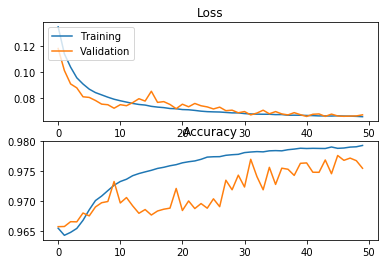

In [28]:
batch_size = 256
nb_epoch = 50


print('Building a model with dropout = 0.4')
model_adam = Sequential()
model_adam.add(Dense(128, input_dim=X_train.shape[1]))
model_adam.add(Activation('softplus'))
model_adam.add(Dropout(0.4))
model_adam.add(Dense(256))
model_adam.add(Activation('softplus'))
model_adam.add(Dropout(0.4))
model_adam.add(Dense(Y_train.shape[1]))
model_adam.add(Activation('softmax'))

model_adam.compile(loss = 'categorical_crossentropy',
                   optimizer = 'Adam',
                   metrics = ['accuracy'])

print('Fit models and use validation_split=0.1')
history_adam = model_adam.fit(X_train, Y_train,
                              batch_size = batch_size,
                              epochs = nb_epoch,
                              verbose = 2,
                              shuffle = True,
                              validation_data = (X_val, Y_val))

loss_adam= history_adam.history.get('loss')
acc_adam = history_adam.history.get('acc')
val_loss_adam = history_adam.history.get('val_loss')
val_acc_adam = history_adam.history.get('val_acc')

print('Visualize the loss and accuracy of both models')
plt.figure(0)
plt.subplot(211)
plt.plot(range(len(loss_adam)), loss_adam,label='Training')
plt.plot(range(len(val_loss_adam)), val_loss_adam,label='Validation')
plt.title('Loss')
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(range(len(acc_adam)), acc_adam,label='Training')
plt.plot(range(len(val_acc_adam)), val_acc_adam,label='Validation')
plt.title('Accuracy')

plt.show()

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Evaluation
def evaluation(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_ = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

    np.set_printoptions(precision=2)
    class_names = ["normal", "botnet"]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names,
                          title = 'Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names, normalize = True,
                          title = 'Normalized confusion matrix')
    print("------------------------------------")
    print("Baseline    : %.6f" % (1 - sum(y_true)/y_true.shape[0]))
    print("Precision   : %f" % precision_score(y_true, y_pred))
    print("Recall      : %f" % recall_score(y_true, y_pred))
    print("F1-Score    : %f" % f1_score(y_true, y_pred))
    print("AUC         : %f" % auc_)
    plt.show()


Confusion matrix, without normalization
[[     0 126578]
 [     0   4473]]
Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]
------------------------------------
Baseline    : 0.965868
Precision   : 0.034132
Recall      : 1.000000
F1-Score    : 0.066010
AUC         : 0.500000


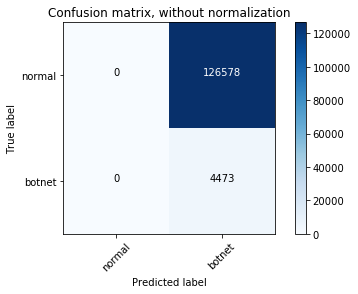

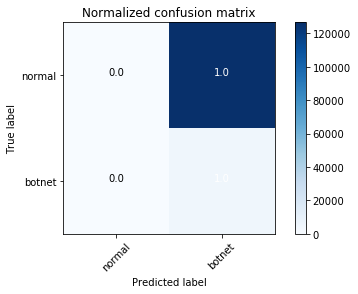

In [30]:
y_true = Y_test[:,1]
y_pred = model_adam.predict_classes(X_test, verbose = 2)
evaluation(y_true, y_pred)
